In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Images.zip'

## Load and view data

In [ ]:
training = pd.read_csv('/content/drive/MyDrive/written_name_train_v2.csv')
validation = pd.read_csv('/content/drive/MyDrive/written_name_validation_v2.csv')

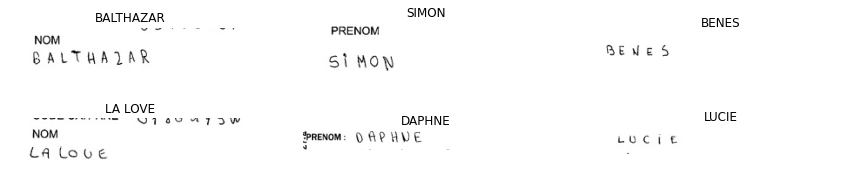

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_dir = '/content/train_v2/train/'+training.loc[i, 'FILENAME']
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(training.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

In [ ]:
print("Number of NaNs in train set      : ", training['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", validation['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [ ]:
training.dropna(axis=0, inplace=True)
validation.dropna(axis=0, inplace=True)

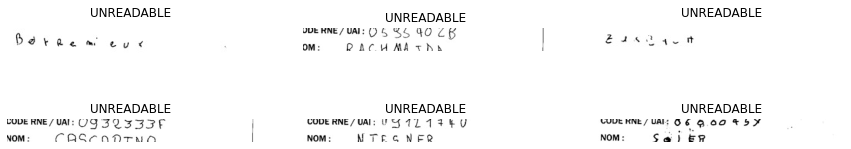

In [ ]:
unreadable = training[training['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_dir = '/content/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
training = training[training['IDENTITY'] != 'UNREADABLE']
validation = validation[validation['IDENTITY'] != 'UNREADABLE']

In [ ]:
training['IDENTITY'] = training['IDENTITY'].str.upper()
validation['IDENTITY'] = validation['IDENTITY'].str.upper()

In [ ]:
training.reset_index(inplace = True, drop=True) 
validation.reset_index(inplace = True, drop=True)

## Preprocessing and preparing the images for training

In [ ]:
def preprocessing(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
training_size = 30000
validation_size= 3000

In [ ]:
training_x = []

for i in range(training_size):
    image_dir = '/content/train_v2/train/'+training.loc[i, 'FILENAME']
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocessing(image)
    image = image/255.
    training_x.append(image)

In [ ]:
validation_x = []

for i in range(validation_size):
    image_dir = '/content/valid_v2/validation/'+validation.loc[i, 'FILENAME']
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocessing(image)
    image = image/255.
    validation_x.append(image)

In [ ]:
training_x = np.array(training_x).reshape(-1, 256, 64, 1)
validation_x = np.array(validation_x).reshape(-1, 256, 64, 1)

## Preparing the labels for CTC Loss

In [ ]:
characters = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_length = 24 # max length of input labels
no_of_characters = len(characters) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(characters.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=characters[ch]
    return ret

In [ ]:
 name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [ ]:
training_y = np.ones([training_size, max_str_length]) * -1
training_label_length = np.zeros([training_size, 1])
training_input_length = np.ones([training_size, 1]) * (num_of_timestamps-2)
training_output = np.zeros([training_size])

for i in range(training_size):
    training_label_length[i] = len(training.loc[i, 'IDENTITY'])
    training_y[i, 0:len(training.loc[i, 'IDENTITY'])]= label_to_num(training.loc[i, 'IDENTITY'])    

In [ ]:
validation_y = np.ones([validation_size, max_str_length]) * -1
validation_label_length = np.zeros([validation_size, 1])
validation_input_length = np.ones([validation_size, 1]) * (num_of_timestamps-2)
validation_output = np.zeros([validation_size])

for i in range(validation_size):
    validation_label_length[i] = len(validation.loc[i, 'IDENTITY'])
    validation_y[i, 0:len(validation.loc[i, 'IDENTITY'])]= label_to_num(validation.loc[i, 'IDENTITY'])    

In [ ]:
print('True label : ',training.loc[100, 'IDENTITY'] , '\ntrain_y : ',training_y[100],'\ntrain_label_length : ',training_label_length[100], 
      '\ntrain_input_length : ', training_input_length[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_length :  [4.] 
train_input_length :  [62.]


## Building our model


In [ ]:
ip_data = Input(shape=(256, 64, 1), name='input')

crnn = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(ip_data)  
crnn = BatchNormalization()(crnn)
crnn = Activation('relu')(crnn)
crnn = MaxPooling2D(pool_size=(2, 2), name='max1')(crnn)

crnn = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(crnn)
crnn = BatchNormalization()(crnn)
crnn = Activation('relu')(crnn)
crnn = MaxPooling2D(pool_size=(2, 2), name='max2')(crnn)
crnn = Dropout(0.3)(crnn)

crnn = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(crnn)
crnn = BatchNormalization()(crnn)
crnn = Activation('relu')(crnn)
crnn = MaxPooling2D(pool_size=(1, 2), name='max3')(crnn)
crnn = Dropout(0.3)(crnn)

# CNN to RNN
crnn = Reshape(target_shape=((64, 1024)), name='reshape')(crnn)
crnn = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(crnn)

## RNN
crnn = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(crnn)
crnn = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(crnn)

## OUTPUT
crnn = Dense(no_of_characters, kernel_initializer='he_normal',name='dense2')(crnn)
y_pred = Activation('softmax', name='softmax')(crnn)

model = Model(inputs=ip_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [ ]:
# the ctc loss function
def ctc_loss_function(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_length], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_loss_function, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
final_model = Model(inputs=[ip_data, labels, input_length, label_length], outputs=ctc_loss)

## Train our model

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
final_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

final_model.fit(x=[training_x, training_y, training_input_length, training_label_length], y=training_output, 
                validation_data=([validation_x, validation_y, validation_input_length, validation_label_length], validation_output),
                epochs=60, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
235/235 [==============================] - 67s 201ms/step - loss: 24.6328 - val_loss: 20.8866
Epoch 2/60
235/235 [==============================] - 46s 195ms/step - loss: 20.1622 - val_loss: 20.1733
Epoch 3/60
235/235 [==============================] - 45s 192ms/step - loss: 19.8348 - val_loss: 19.9635
Epoch 4/60
235/235 [==============================] - 45s 190ms/step - loss: 19.4359 - val_loss: 19.2713
Epoch 5/60
235/235 [==============================] - 46s 196ms/step - loss: 18.8547 - val_loss: 18.3084
Epoch 6/60
235/235 [==============================] - 45s 192ms/step - loss: 17.9304 - val_loss: 17.8283
Epoch 7/60
235/235 [==============================] - 45s 191ms/step - loss: 16.8161 - val_loss: 16.2210
Epoch 8/60
235/235 [==============================] - 46s 195ms/step - loss: 15.2029 - val_loss: 15.3304
Epoch 9/60
235/235 [==============================] - 45s 191ms/step - loss: 13.3084 - val_loss: 13.9643
Epoch 10/60
235/235 [==============================] - 

## Check model performance on validation set

In [ ]:
preds = model.predict(validation_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(validation_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = validation.loc[0:validation_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(validation_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/validation_size))

Correct characters predicted : 87.22%
Correct words predicted      : 73.17%


## Some predictions on test set

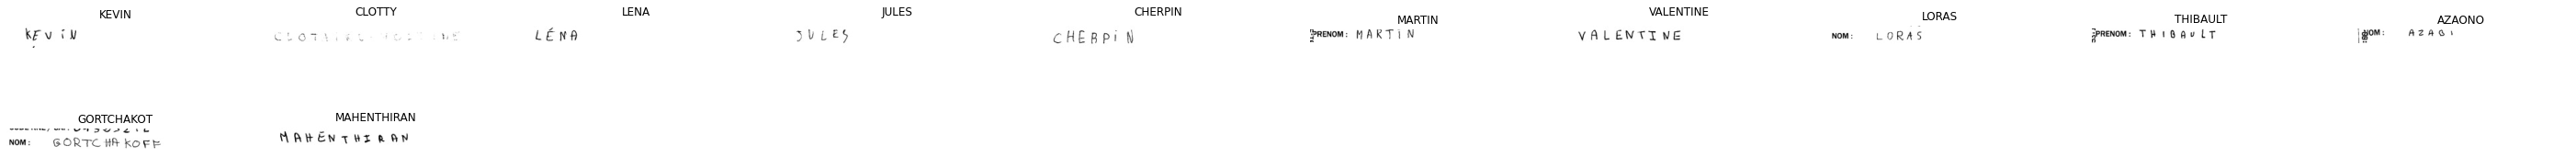

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/written_name_test_v2.csv')

plt.figure(figsize=(50, 70))
for i in range(12):
    ax = plt.subplot(30, 10, i+1)
    image_dir = '/content/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocessing(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)